# Data Import

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('owid-covid-data.csv')
print(df.shape)
df.head()

(251343, 67)


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN


# Clustering k-means

In [4]:
# Filter out locations that are not countries
not_countries = ["World", "Europe", "Asia", "North America", "South America", "Africa", "Oceania", "European Union", "International", "International conveyance", "High income", "Low income", "Upper middle income", "Lower middle income"]
df = df[~df.location.isin(not_countries)]
df.shape

(237227, 67)

In [5]:
median_stringency_index = df.groupby('location').stringency_index.median()
latest_gdp_per_capita = df.groupby('location').gdp_per_capita.last()
max_total_cases_by_country = df.groupby('location').total_cases_per_million.max()

# Combine the two series into a dataframe
df_ = pd.DataFrame({'latest_gdp_per_capita': latest_gdp_per_capita, 'median_stringency_index': median_stringency_index, 'max_total_cases_by_country': max_total_cases_by_country})

# 1. Remove nan values
df_ = df_.dropna()

# 2. Scale the data 0 to 1
df_ = (df_ - df_.min()) / (df_.max() - df_.min())

df_.head() 

,latest_gdp_per_capita,median_stringency_index,max_total_cases_by_country
location,,,
Afghanistan,0.009828,0.116830,0.006609
Albania,0.095827,0.467461,0.164640
Algeria,0.113977,0.595512,0.007991
Angola,0.044363,0.662272,0.003651
Argentina,0.157151,0.850631,0.308959


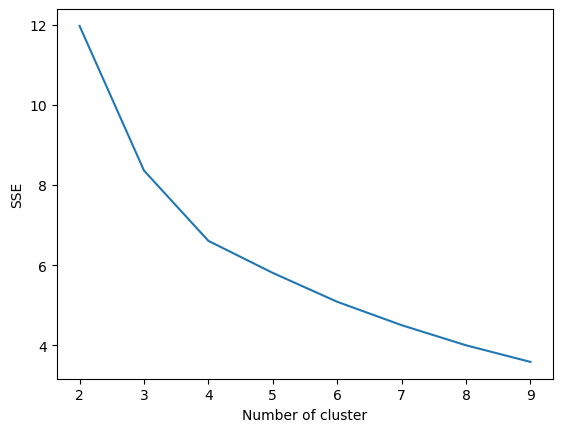

In [6]:
# K-mean clustering
# Turn off warnings
import warnings
warnings.filterwarnings("ignore")

# Elbow method
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sse = {}
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(df_)
    df_["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [7]:
# Silhouette analysis

for n_cluster in range(2, 10):
    kmeans = KMeans(n_clusters=n_cluster).fit(df_)
    label = kmeans.labels_
    sil_coeff = silhouette_score(df_, label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))

For n_clusters=2, The Silhouette Coefficient is 0.5492535054703622
For n_clusters=3, The Silhouette Coefficient is 0.6675295166677834
For n_clusters=4, The Silhouette Coefficient is 0.6518978860168798
For n_clusters=5, The Silhouette Coefficient is 0.6808336481356734
For n_clusters=6, The Silhouette Coefficient is 0.7639268624384818
For n_clusters=7, The Silhouette Coefficient is 0.7949004829618995
For n_clusters=8, The Silhouette Coefficient is 0.8298174713090714
For n_clusters=9, The Silhouette Coefficient is 0.8355616622442689


In [14]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(df_)

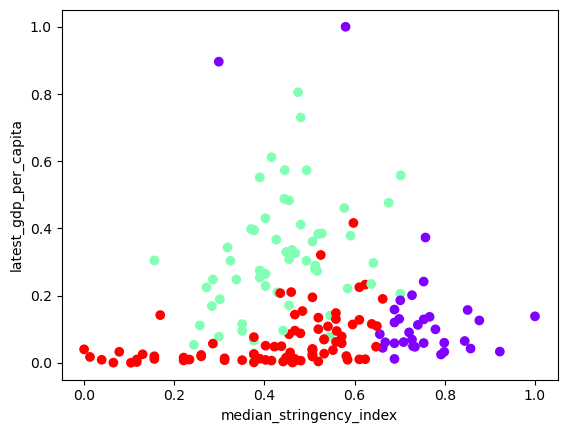

In [15]:
# Graph the clusters

plt.scatter( df_.median_stringency_index, df_.latest_gdp_per_capita, c=kmeans.labels_, cmap='rainbow')
plt.xlabel('median_stringency_index')
plt.ylabel('latest_gdp_per_capita')
plt.show()

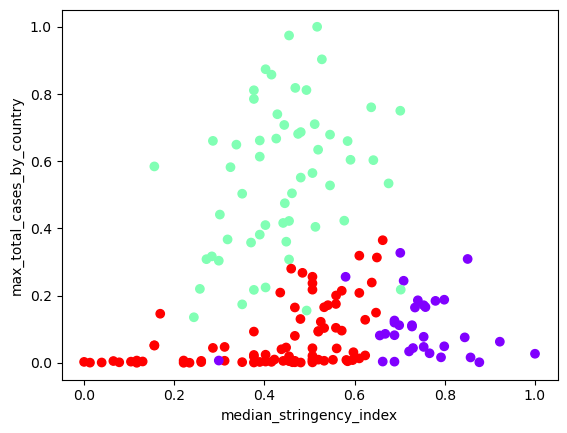

In [16]:
# Graph the clusters
plt.scatter( df_.median_stringency_index, df_.max_total_cases_by_country, c=kmeans.labels_, cmap='rainbow')
plt.xlabel('median_stringency_index')
plt.ylabel('max_total_cases_by_country')
plt.show()

In [17]:
# Export clusters 
df_location_clusters = pd.DataFrame({'location': df_.index, 'cluster': kmeans.labels_})
# Rename cluster 0 to "Low total cases, high stringency", 1 to "High total cases, medium stringency", 2 to "Low total cases low stringency"
df_location_clusters['cluster'] = df_location_clusters['cluster'].replace({0: 'Low total cases, high stringency', 1: 'High total cases, medium stringency', 2: 'Low total cases low stringency'})

df_location_clusters.to_csv('location_clusters.csv', index=False)